In [7]:
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import glob
import copy
import random
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        temp_video = os.path.basename(video_path) 
   
        matched_label = self.labels[self.labels["file"] == temp_video]
        
        if matched_label.empty:
            raise ValueError(f"Label for video '{temp_video}' not found in labels DataFrame.")
        
        label = matched_label.iloc[0, 1] 
        if label == 'FAKE':
            label = 0
        elif label == 'REAL':
            label = 1
        
        for i, frame in enumerate(self.frame_extract(video_path)):
            frames.append(self.transform(frame))
            if len(frames) == self.count:
                break
        
        frames = torch.stack(frames)
        frames = frames[:self.count]
        
        return frames, label

    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [10]:
def number_of_real_and_fake_videos(data_list, labels):
    fake = 0
    real = 0
    for video_path in data_list:
        temp_video = os.path.basename(video_path) 
        matched_label = labels[labels["file"] == temp_video]
        
        if not matched_label.empty:
            label = matched_label.iloc[0, 1]
            if label == 'FAKE':
                fake += 1
            elif label == 'REAL':
                real += 1
        else:
            print(f"Warning: {temp_video} not found in labels file.")
            
    return real, fake


                 file label
0             000.mp4  REAL
1         000_003.mp4  FAKE
2             001.mp4  REAL
3         001_870.mp4  FAKE
4             002.mp4  REAL
...               ...   ...
23181  ybbrkacebd.mp4  REAL
23182  ybnucgidtu.mp4  REAL
23183  yexeazbqig.mp4  REAL
23184  yhylappzid.mp4  REAL
23185  yljecirelf.mp4  REAL

[23186 rows x 2 columns]
train :  5160
test :  1290
TRAIN: Real: 2078  Fake: 3081
TEST: Real: 1230  Fake: 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-21..263].


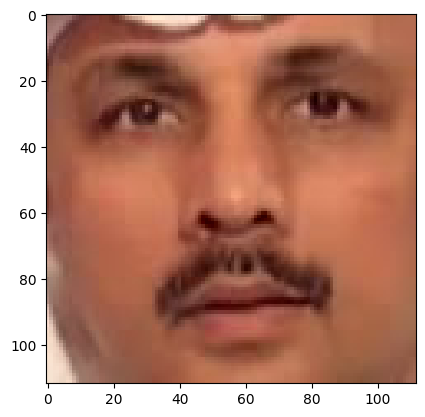

In [11]:
header_list = ["file","label"]

video_files = glob.glob(r'C:\Users\KK\Desktop\dfd\Data\CroppedFaces\*mp4')
Labels = pd.read_csv(r'C:\Users\KK\Desktop\dfd\Data\Gobal_metadata.csv', names=header_list)

print(Labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))

print("TRAIN: Real:", number_of_real_and_fake_videos(train_videos, Labels)[0], " Fake:", number_of_real_and_fake_videos(train_videos, Labels)[1])
print("TEST: Real:", number_of_real_and_fake_videos(valid_videos, Labels)[0], " Fake:", number_of_real_and_fake_videos(valid_videos, Labels)[1])



im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,Labels,sequence_length = 10,transform = train_transforms)
val_data = video_dataset(valid_videos,Labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 16,shuffle = True,num_workers = 0)
valid_loader = DataLoader(val_data,batch_size = 16,shuffle = True,num_workers = 0)

image,label = train_data[0]
im_plot(image[0,:,:,:])

In [12]:
for batch in train_loader:
    print("Loaded a batch successfully")
    break  

Loaded a batch successfully


In [13]:
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [10]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))
torch.save(model.state_dict(),'./content/checkpoint.pt')


C:\Users\KK\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KK\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
import pandas as pd
from tqdm import tqdm

def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    
    print(f"\nStarting Epoch {epoch}/{num_epochs}")

    progress_bar = tqdm(data_loader, desc=f"Training Epoch [{epoch}/{num_epochs}]")

    for i, (inputs, targets) in enumerate(progress_bar):
        if torch.cuda.is_available():
            targets = targets.cuda(non_blocking=True)
            inputs = inputs.cuda(non_blocking=True)
            
        _, outputs = model(inputs)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)
        
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))

        print(f"Batch {i+1}/{len(data_loader)} - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}%")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=losses.avg, acc=accuracies.avg)

    print(f"Epoch {epoch} Completed - Avg Loss: {losses.avg:.4f}, Avg Accuracy: {accuracies.avg:.4f}%")


    torch.save({
        'epoch': epoch,  
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss, 
    }, './checkpoint.pt')

    
    return losses.avg, accuracies.avg

def test(epoch, model, data_loader, criterion, device="cuda" if torch.cuda.is_available() else "cpu"):
    print(f'Testing - Epoch {epoch}')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    true_labels = []
    predictions = []

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc=f"Testing Epoch [{epoch}]")
        for i, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)

            _, outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)

            true_labels.extend(targets.cpu().numpy())
            predictions.extend(outputs.argmax(dim=1).cpu().numpy())

            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            
            progress_bar.set_postfix({
                "Loss": f"{losses.avg:.4f}",
                "Acc": f"{accuracies.avg:.4f}%"
            })

    print(f'\nTest Accuracy: {accuracies.avg:.4f}%')
    return true_labels, predictions, losses.avg, accuracies.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)
    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100 * n_correct_elems / batch_size

In [2]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) 
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) 
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)



In [4]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [14]:
import time
lr = 1e-5

num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,2):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
    # time.sleep(1200)
torch.save(model.state_dict(), './content/checkpoint.pt')
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

NameError: name 'model' is not defined

In [ ]:
# lr = 1e-5

num_epochs = 15

# optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

criterion = nn.CrossEntropyLoss().cuda()
# train_loss_avg =[]
# train_accuracy = []
# test_loss_avg = []
# test_accuracy = []
for epoch in range(15,16):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_avg': train_loss_avg,
    'train_accuracy': train_accuracy,
    'test_loss_avg': test_loss_avg,
    'test_accuracy': test_accuracy
}, './checkpoint.pt')
    plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
    plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
    print(confusion_matrix(true,pred))
    print_confusion_matrix(true,pred)
    # time.sleep(300)

In [ ]:
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

In [30]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_avg': train_loss_avg,
    'train_accuracy': train_accuracy,
    'test_loss_avg': test_loss_avg,
    'test_accuracy': test_accuracy
}, './checkpoint.pt')



In [11]:
# Load the checkpoint
checkpoint = torch.load('./checkpoint.pt')
model = Model(2).cuda()
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()
# Restore tracking variables
train_loss_avg = checkpoint['train_loss_avg']
train_accuracy = checkpoint['train_accuracy']
test_loss_avg = checkpoint['test_loss_avg']
test_accuracy = checkpoint['test_accuracy']


C:\Users\KK\AppData\Local\Temp\ipykernel_13612\4194397936.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoint.pt')
C:\Users\KK\AppData\